In [1]:
# Импорт библиотек
import os
import time
import KU_TU
import GTU
import SP
import mat_properties as prop
import numpy as n
import pandas as pd
from scipy.optimize import root

# таблица номинального режима
gas_streams0 = pd.read_excel("streams0.xlsx", sheet_name="gas", index_col=0)
water_streams0 = pd.read_excel(
    "streams0.xlsx", sheet_name="water", index_col=0)
GTU_ISO = pd.read_excel("input.xlsx", sheet_name="ISO", index_col=0)
GTU_input = pd.read_excel("input.xlsx", sheet_name="GTU_input", index_col=0)
# рабочая таблица (=номинал в 1 итерации)
gas_streams = pd.read_excel("streams.xlsx", sheet_name="gas", index_col=0)
water_streams = pd.read_excel("streams.xlsx", sheet_name="water", index_col=0)
# рабочая таблица показателей блоков
heaters = pd.read_excel("blocks.xlsx", sheet_name="heaters", index_col=0)
electric = pd.read_excel("blocks.xlsx", sheet_name="electric", index_col=0)

# Состав газов в номинале
gasmix = "Nitrogen*Oxygen*CO2*Water*Argon"
# Считывание рефпропа
RP = prop.init_REFPROP(r"C:\Program Files (x86)\REFPROP")
fractiongas0 = (
    gas_streams0.at["GTU-PEVD", "N2"],
    gas_streams0.at["GTU-PEVD", "O2"],
    gas_streams0.at["GTU-PEVD", "CO2"],
    gas_streams0.at["GTU-PEVD", "H2O"],
    gas_streams0.at["GTU-PEVD", "Ar"],
)

gas0 = prop.Materials_prop(
    gasmix,
    fractiongas0,
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    prop.REFPROP_s_q,
    RP=RP,
)
water = prop.Materials_prop(
    "water",
    [1.0, 0, 0, 0, 0],
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    prop.REFPROP_s_q,
    RP=RP,
)

# Задание энтальпий газа в номинальном режиме
Temperatures = gas_streams0.loc["GTU-KU":"GPK-out", "T"]
Pressure = gas_streams0.loc["GTU-KU", "P"]
Enthalpies = list(map(lambda x: gas0.p_t(Pressure, x)["h"], Temperatures))
gas_streams0.loc["GTU-KU":"GPK-out", "H"] = Enthalpies

############################################################
# Расчет ГТУ
Gas_turbine = GTU.gtu(GTU_ISO, GTU_input, "GTU-KU")
Gas_turbine_res = Gas_turbine.calc()
electric.at["GTU", "N"] = Gas_turbine_res["N"]
electric.at["GTU", "KPD"] = Gas_turbine_res["eff"]
electric.at["DK", "N"] = Gas_turbine_res["Ndk"]
gas_streams = pd.read_excel("streams.xlsx", sheet_name="gas", index_col=0)
gas_streams.at["GTU-KU", "T"] = Gas_turbine_res["T"]
gas_streams.at["GTU-KU", "G"] = Gas_turbine_res["G"]
gas_streams.at["GTU-KU", "P"] = 0.1
gas_streams.at['GTU-KU', 'H'] = gas0.p_t(
    gas_streams.at['GTU-KU', 'P'], gas_streams.at['GTU-KU', 'T'])['h']
Gas_turbine_composition = pd.read_excel(
    "input.xlsx", sheet_name="Gas_composition0", index_col=0)

# Параметры газа на выходе в КУ
gas_streams.loc["GTU-PEVD", "T":"P"] = gas_streams.loc["GTU-KU", "T":"P"]
gas_streams.at["GTU-PEVD", "G"] = gas_streams.loc["GTU-KU", "G"]
gas_streams.at["GTU-PEVD",
               "N2":"Ar"] = Gas_turbine_composition.loc["Fraction", "N2":"Ar"]

############################################################
# Теплосеть
gas_streams.at["AIR", "T":"P"] = [GTU_input.loc["tair", 1], 0.1]
water_streams.at["AIR", "T":"P"] = [GTU_input.loc["tair", 1], 0.1]
Tnv = gas_streams.at["AIR", "T"]
water_streams.at["SWIN-TURB", "T"] = SP.Tset(Tnv)[1]
water_streams.at["SP2-WOUT", "T"] = SP.Tset(Tnv)[0]
# print(water_streams)
############################################################

# Состав газов при частичной нагрузке
fractiongas = (
    gas_streams.at["GTU-PEVD", "N2"],
    gas_streams.at["GTU-PEVD", "O2"],
    gas_streams.at["GTU-PEVD", "CO2"],
    gas_streams.at["GTU-PEVD", "H2O"],
    gas_streams.at["GTU-PEVD", "Ar"],
)
gas1 = prop.Materials_prop(
    gasmix,
    fractiongas,
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    prop.REFPROP_s_q,
    RP=RP,
)

# Основные константы
Calcmethod = "hybr"
KPD_PN = 0.8074
KPD_KN = 0.75
KPD_to = 0.99
KPD_SP = 0.99

Calctolerance = 10**-2
Teplo = 0
Maxiterations_KU_TU = 20
Maxiterations_cotel = 4
Maxiterations_turbine = 30

# Claas KU+TU
KU_and_TU = KU_TU.ku_tu(gas0, gas1,  water, gas_streams0, gas_streams, water_streams0,
                        water_streams, heaters, electric, Calcmethod, KPD_SP, KPD_KN, KPD_to, KPD_PN)

start_time = time.time()

KU_and_TU.calculate(Teplo, Calctolerance, Maxiterations_KU_TU,
                    Maxiterations_cotel, Maxiterations_turbine)

print("Степень сухости пара в ЭВД: ", water.p_h(
    water_streams.at["EVD-IVD", "P"], water_streams.at["EVD-IVD", "H"])["Q"],)
print("Степень сухости пара в ГПК: ", water.p_h(
    water_streams.at["GPK-IND", "P"], water_streams.at["GPK-IND", "H"])["Q"],)

print(f"fin КУ и ТУ:--- {round((time.time() - start_time), 1)} сек. ---")

Достигнуто максимальное количество итераций контура высокого давления
Fin котел-утилизатора:--- 11.47 сек. ---
dQ/Qsumm -0.0014415661006680818
Fin турбоустановка:--- 0.08 сек. ---
Достигнуто максимальное количество итераций контура ГПК
Достигнуто максимальное количество итераций контура низкого давления
Достигнуто максимальное количество итераций контура ГПК
Достигнуто максимальное количество итераций контура ГПК
Достигнуто максимальное количество итераций контура низкого давления
Достигнуто максимальное количество итераций контура ГПК
Достигнуто максимальное количество итераций контура ГПК
Достигнуто максимальное количество итераций контура низкого давления
Повышена точность расчета котла для увеличения сходимости
dQ/Q ПЕВД+ИВД+ЭВД 2.7920118654547204
dQ/Q ПЕВД+ИВД+ЭВД -1.599703855360991
dQ/Q ПЕВД+ИВД+ЭВД 0.7863384354120687
dQ/Q ПЕВД+ИВД+ЭВД -0.3903088880274336
Достигнуто максимальное количество итераций контура высокого давления
dQ/Q ППНД+ИНД+ГПК -0.010004377310721619
Достигнуто макси

In [2]:
# Вывод газовых потоков
gas_streams

,T,P,H,G,N2,O2,CO2,H2O,Ar
AIR,15.000000,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTU-KU,542.010558,0.1,958.533980,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
GTU-PEVD,542.010558,0.1,958.533980,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
PEVD-IVD,467.858876,0.1,873.815324,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
IVD-EVD,308.286566,0.1,696.420678,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
EVD-PPND,235.496551,0.1,617.645561,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
PPND-IND,232.664096,0.1,614.604881,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
IND-GPK,175.020293,0.1,553.085273,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
GPK-out,105.368407,0.1,479.546157,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065


In [3]:
# Вывод водяных потоков
water_streams

,T,P,H,G,S,X
AIR,15.000000,0.100000,NaN,NaN,NaN,NaN
PEVD-DROSVD,511.553509,8.293917,3424.644815,62.504430,NaN,NaN
IVD-PEVD,300.333987,8.628386,2748.993820,62.504430,NaN,NaN
EVD-IVD,298.136217,8.628386,1334.304387,62.504430,NaN,NaN
PEN-EVD,165.996113,8.628386,706.072706,62.504430,NaN,NaN
BND-PEN,164.222963,0.687536,693.848896,62.504430,NaN,NaN
PPND-DROSND,208.698702,0.682163,2865.525943,14.639768,NaN,NaN
IND-PPND,164.222963,0.687536,2761.992717,14.639768,NaN,NaN
GPK-IND,163.063106,0.687536,688.807418,77.144198,NaN,NaN
GPK-REC,163.063106,0.687536,688.807418,83.869364,NaN,NaN


In [4]:
Errors_water = abs(water_streams - water_streams0)/water_streams0*100
Errors_gas = abs(gas_streams-gas_streams0)/gas_streams0*100
Errors_gas
Errors_water

,G,H,P,S,T,X
AIR,NaN,NaN,NaN,NaN,NaN,NaN
BND-PEN,1.412572,0.322753,1.272831,NaN,0.312859,NaN
DOOTB1,1.299645,0.012546,1.092296,0.077033,NaN,NaN
DOOTB2,1.299645,0.004558,1.221088,0.082423,0.066497,NaN
DROSND-TURBND,0.814579,0.205508,1.316153,0.090337,1.381608,NaN
DROSVD-TURBVD,1.412572,0.061923,1.339184,NaN,0.072794,NaN
ENDOFVD,1.412572,0.048555,1.281554,NaN,0.234690,NaN
EVD-IVD,1.412572,0.272348,1.344769,NaN,0.222149,NaN
GPK-BYPASS,NaN,NaN,NaN,NaN,NaN,NaN
GPK-IND,1.299645,0.961372,1.272831,NaN,0.933715,NaN


In [5]:
gas_streams0

,T,P,H,G,N2,O2,CO2,H2O,Ar
GTU-KU,542.10,0.1,958.637030,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
GTU-PEVD,542.10,0.1,958.637030,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
PEVD-IVD,468.05,0.1,874.031830,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
IVD-EVD,309.20,0.1,697.417326,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
EVD-PPND,235.90,0.1,618.078812,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
PPND-IND,233.00,0.1,614.965387,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
IND-GPK,175.50,0.1,553.594555,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
GPK-out,106.90,0.1,481.155410,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
electric

,Ni,N,KPDm,KPD
PEN,0.764042,0.787620,0.970064,0.717659
CVD,NaN,NaN,NaN,NaN
CND,NaN,NaN,NaN,NaN
GTU,NaN,150.750600,NaN,33.348086
DK,NaN,6.269747,NaN,NaN
Turbine,75.626053,NaN,NaN,NaN
Tots1,36.188730,NaN,NaN,0.849381
Tots2,9.600538,NaN,NaN,0.837241
Tots3,24.232026,NaN,NaN,0.814968
Tots4,5.604759,NaN,NaN,0.857388


In [7]:
heaters

,Qw,Qg,KPD
PEVD,42229.065804,42655.622025,0.99
IVD,88424.563622,89317.741033,0.99
EVD,39266.434840,39663.065495,0.99
PPND,1515.664477,1530.974220,0.99
IND,30665.212414,30974.962035,0.99
GPK,36656.485223,37026.752750,0.99
SP2,NaN,NaN,NaN
SP1,NaN,NaN,NaN
OD,NaN,NaN,NaN


In [8]:
GTU_input

,1,2,3,4,5,6
tair,15,NaN,NaN,NaN,NaN,NaN
n,1,NaN,NaN,NaN,NaN,NaN
Pin,0,NaN,NaN,NaN,NaN,NaN
Pout,0,NaN,NaN,NaN,NaN,NaN


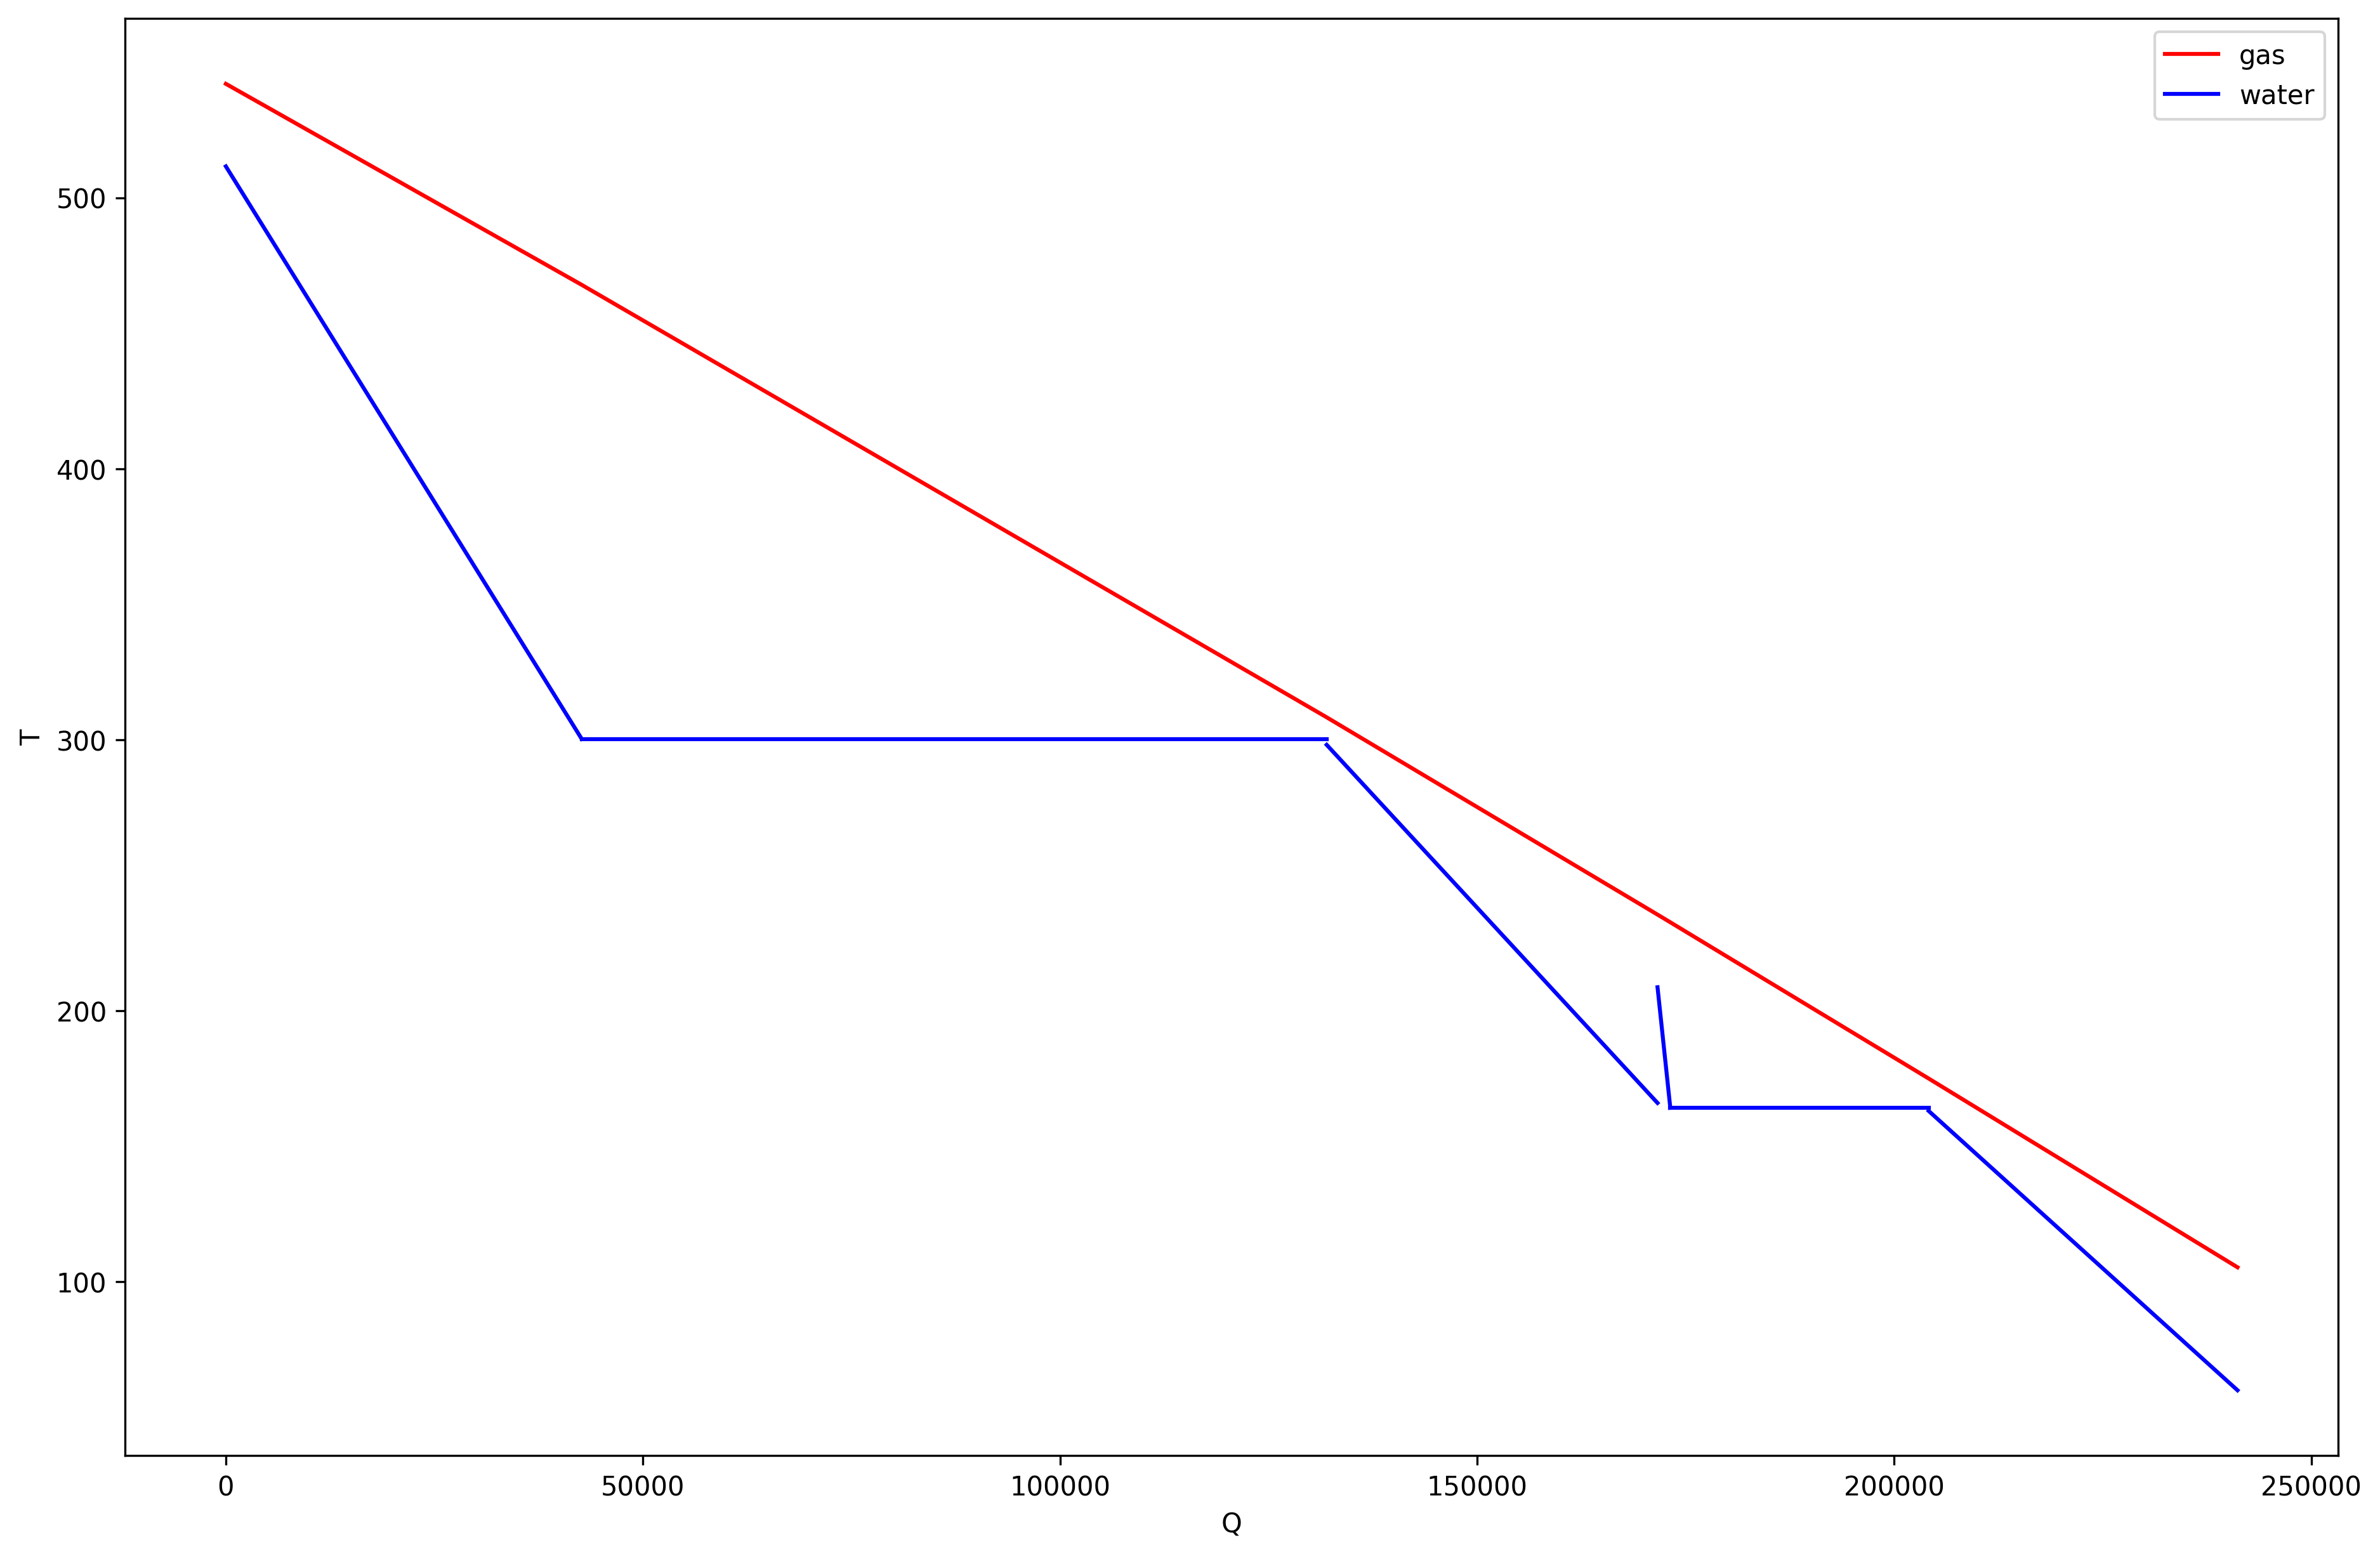

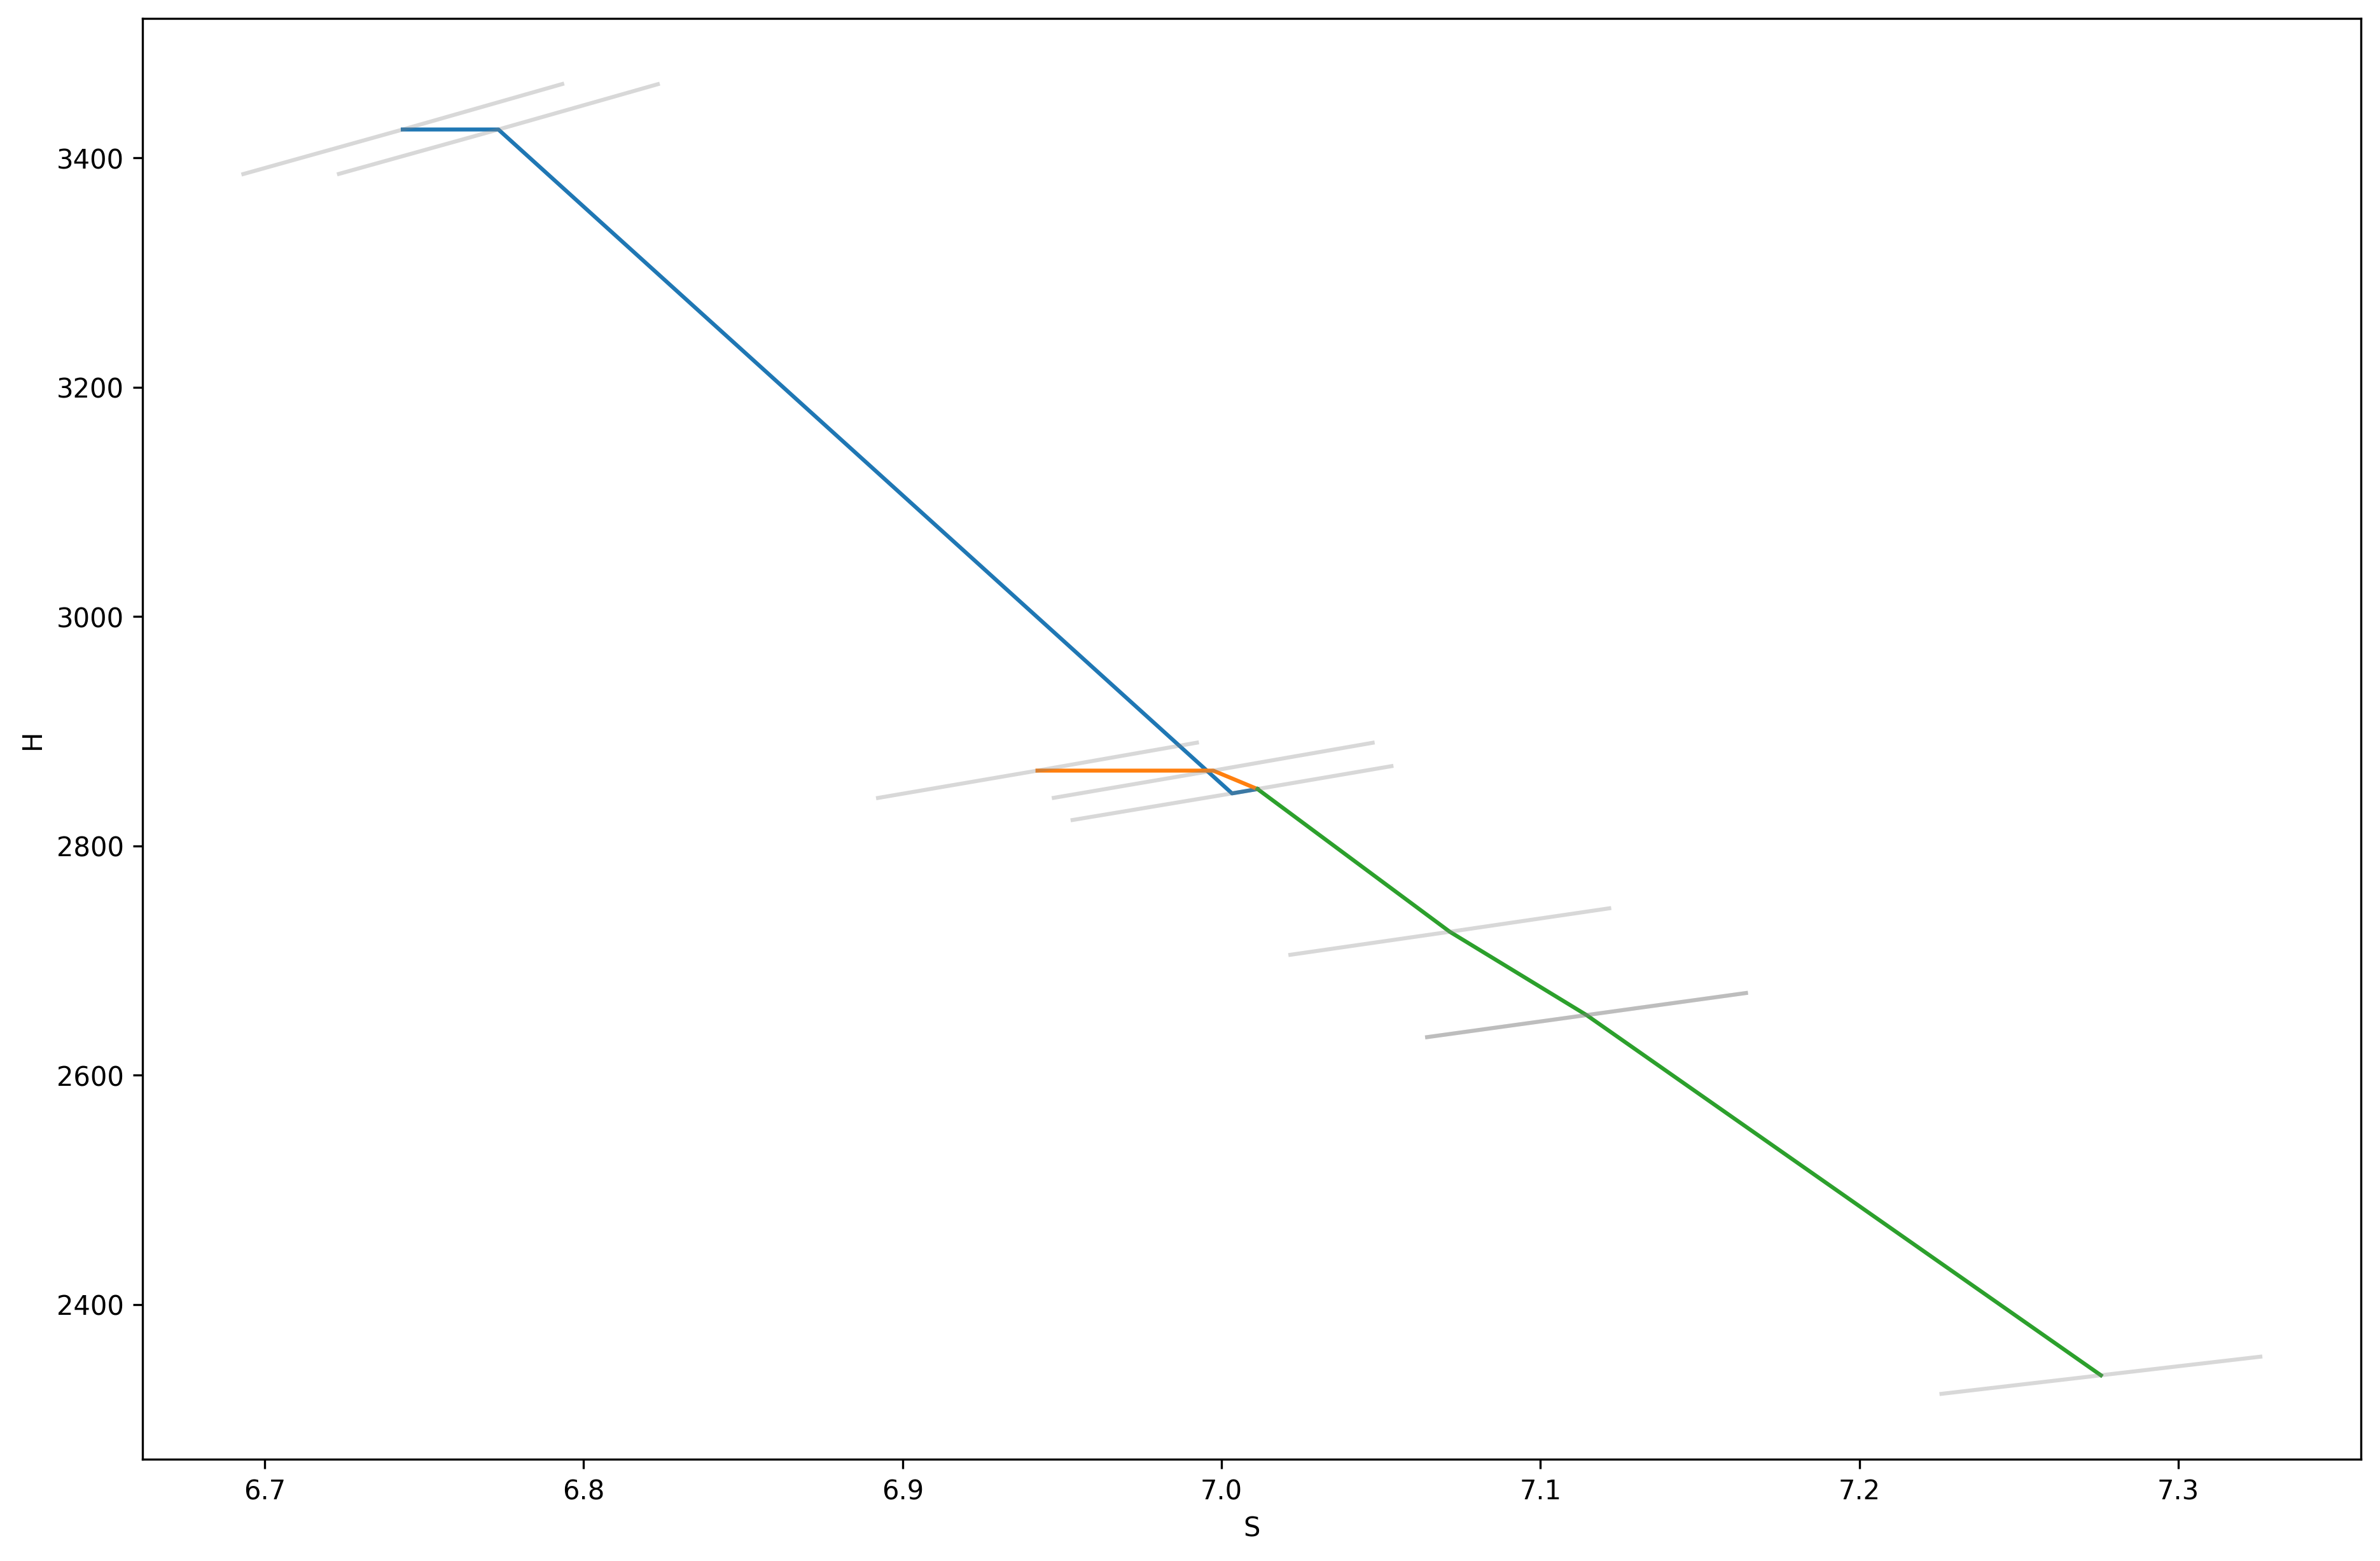

,T,P,H,G,S,X
AIR,15.000000,0.100000,NaN,NaN,NaN,NaN
PEVD-DROSVD,511.553509,8.293917,3424.644815,62.504430,6.743272,NaN
IVD-PEVD,300.333987,8.628386,2748.993820,62.504430,NaN,NaN
EVD-IVD,298.136217,8.628386,1334.304387,62.504430,NaN,NaN
PEN-EVD,165.996113,8.628386,706.072706,62.504430,NaN,NaN
BND-PEN,164.222963,0.687536,693.848896,62.504430,NaN,NaN
PPND-DROSND,208.698702,0.682163,2865.525943,14.639768,6.942299,NaN
IND-PPND,164.222963,0.687536,2761.992717,14.639768,NaN,NaN
GPK-IND,163.063106,0.687536,688.807418,77.144198,NaN,NaN
GPK-REC,163.063106,0.687536,688.807418,83.869364,NaN,NaN


In [9]:
import Grafiki

Grafiki.Q_t_diagram(gas_streams, water_streams, heaters, 15, 10)
Grafiki.H_S_diagram(water, water_streams, 15, 10)
water_streams

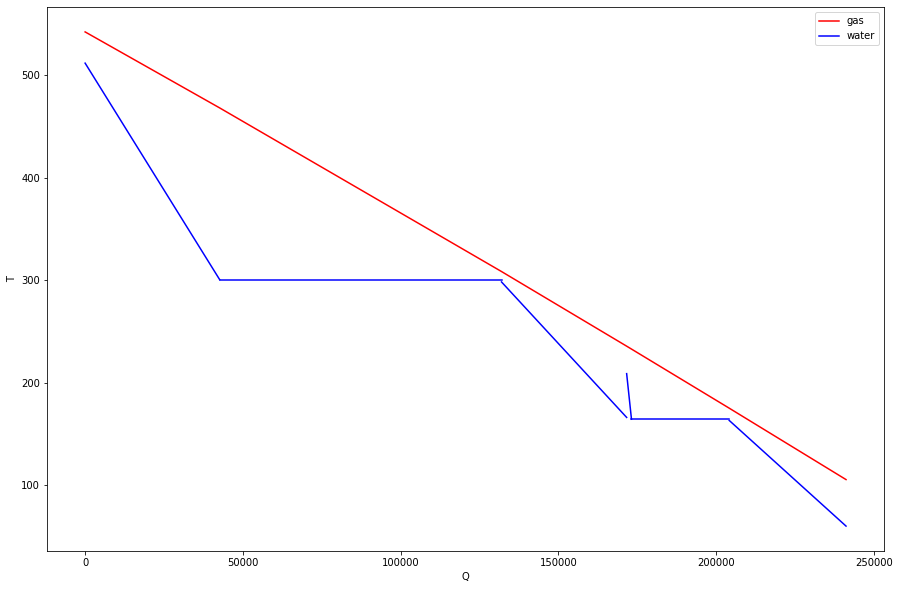

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
Qg = [0,
      heaters.loc['PEVD', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg'] +
      heaters.loc['EVD', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg'] +
      heaters.loc['EVD', 'Qg']+heaters.loc['PPND', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg']+heaters.loc['EVD',
                                                                     'Qg']+heaters.loc['PPND', 'Qg']+heaters.loc['IND', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg']+heaters.loc['EVD', 'Qg'] +
      heaters.loc['PPND', 'Qg'] +
      heaters.loc['IND', 'Qg']+heaters.loc['GPK', 'Qg']
      ]
Qw = [0,
      heaters.loc['PEVD', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg'] +
      heaters.loc['EVD', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg'] +
      heaters.loc['EVD', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg'] +
      heaters.loc['EVD', 'Qg']+heaters.loc['PPND', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg']+heaters.loc['EVD',
                                                                     'Qg']+heaters.loc['PPND', 'Qg']+heaters.loc['IND', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg']+heaters.loc['EVD',
                                                                     'Qg']+heaters.loc['PPND', 'Qg']+heaters.loc['IND', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg']+heaters.loc['EVD', 'Qg'] +
      heaters.loc['PPND', 'Qg'] +
      heaters.loc['IND', 'Qg']+heaters.loc['GPK', 'Qg']
      ]
Tg = gas_streams.loc['GTU-PEVD':'GPK-out', 'T']
Tw = [water_streams.loc['PEVD-DROSVD', 'T'],
      water_streams.loc['IVD-PEVD', 'T'],
      water_streams.loc['IVD-PEVD', 'T'],
      water_streams.loc['EVD-IVD', 'T'],
      water_streams.loc['PEN-EVD', 'T'],
      water_streams.loc['PPND-DROSND', 'T'],
      water_streams.loc['IND-PPND', 'T'],
      water_streams.loc['IND-PPND', 'T'],
      water_streams.loc['GPK-REC', 'T'],
      water_streams.loc['REC-GPK', 'T'],
      ]
plt.plot(Qg, Tg, color='red')
plt.plot(Qw[0:2], Tw[0:2], color='blue')
plt.plot(Qw[1:3], Tw[1:3], color='blue')
plt.plot(Qw[3:5], Tw[3:5], color='blue')
plt.plot(Qw[5:7], Tw[5:7], color='blue')
plt.plot(Qw[6:8], Tw[6:8], color='blue')
plt.plot(Qw[8:10], Tw[8:10], color='blue')
plt.xlabel('Q')
plt.ylabel('T')
plt.legend(['gas', 'water'])
plt.show()

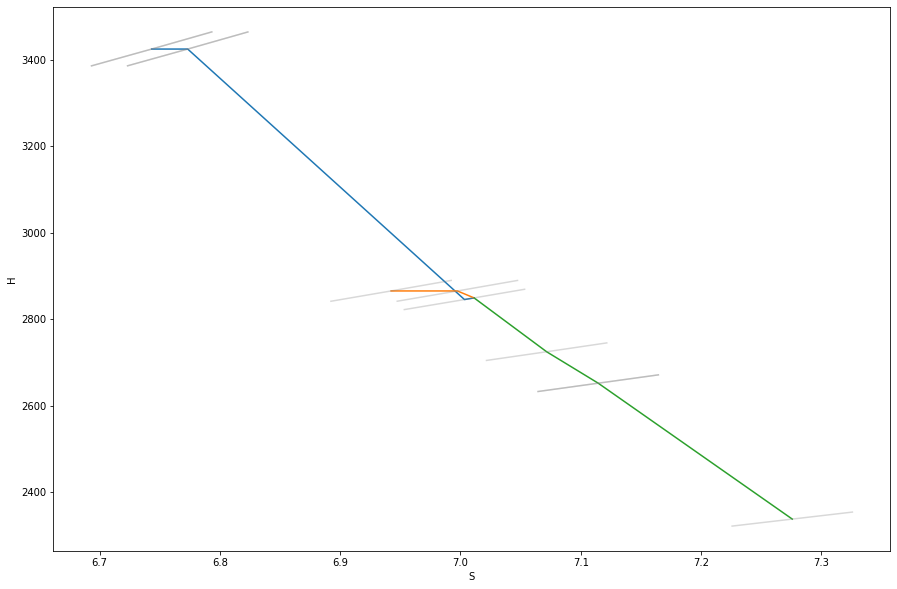

,T,P,H,G,S,X
AIR,15.000000,0.100000,NaN,NaN,NaN,NaN
PEVD-DROSVD,511.553509,8.293917,3424.644815,62.504430,6.743272,NaN
IVD-PEVD,300.333987,8.628386,2748.993820,62.504430,NaN,NaN
EVD-IVD,298.136217,8.628386,1334.304387,62.504430,NaN,NaN
PEN-EVD,165.996113,8.628386,706.072706,62.504430,NaN,NaN
BND-PEN,164.222963,0.687536,693.848896,62.504430,NaN,NaN
PPND-DROSND,208.698702,0.682163,2865.525943,14.639768,6.942299,NaN
IND-PPND,164.222963,0.687536,2761.992717,14.639768,NaN,NaN
GPK-IND,163.063106,0.687536,688.807418,77.144198,NaN,NaN
GPK-REC,163.063106,0.687536,688.807418,83.869364,NaN,NaN


In [11]:
import matplotlib.pyplot as plt


water_streams.at['PEVD-DROSVD', 'S'] = water.p_h(
    water_streams.at['PEVD-DROSVD', 'P'], water_streams.at['PEVD-DROSVD', 'H'])['s']
water_streams.at['PPND-DROSND', 'S'] = water.p_h(
    water_streams.at['PPND-DROSND', 'P'], water_streams.at['PPND-DROSND', 'H'])['s']

plt.figure(figsize=(15, 10))
Hvd = [water_streams.at['PEVD-DROSVD', 'H'],
       water_streams.at['DROSVD-TURBVD', 'H'],
       water_streams.at['ENDOFVD', 'H'],
       water_streams.at['SMESHEND', 'H'],
       ]
Svd = [water_streams.at['PEVD-DROSVD', 'S'],
       water_streams.at['DROSVD-TURBVD', 'S'],
       water_streams.at['ENDOFVD', 'S'],
       water_streams.at['SMESHEND', 'S'],
       ]
Hsm = [water_streams.at['PPND-DROSND', 'H'],
       water_streams.at['DROSND-TURBND', 'H'],
       water_streams.at['SMESHEND', 'H'],
       ]
Ssm = [water_streams.at['PPND-DROSND', 'S'],
       water_streams.at['DROSND-TURBND', 'S'],
       water_streams.at['SMESHEND', 'S'],
       ]
Hnd = [water_streams.at['SMESHEND', 'H'],
       water_streams.at['DOOTB2', 'H'],
       water_streams.at['DOOTB1', 'H'],
       water_streams.at['INCND', 'H'],
       water_streams.at['INKOND', 'H'],
       ]
Snd = [water_streams.at['SMESHEND', 'S'],
       water_streams.at['DOOTB2', 'S'],
       water_streams.at['DOOTB1', 'S'],
       water_streams.at['INCND', 'S'],
       water_streams.at['INKOND', 'S'],
       ]

# Давления
stream = 'PEVD-DROSVD'
H1 = [water.p_s(water_streams.at[stream, 'P'], water_streams.at[stream, 'S']-0.05)['h'], water_streams.at[stream,
                                                                                                          'H'], water.p_s(water_streams.at[stream, 'P'], water_streams.at[stream, 'S']+0.05)['h']]
S1 = [water_streams.at[stream, 'S']-0.05,
      water_streams.at[stream, 'S'], water_streams.at[stream, 'S']+0.05]
stream = 'DROSVD-TURBVD'
H2 = [water.p_s(water_streams.at[stream, 'P'], water_streams.at[stream, 'S']-0.05)['h'], water_streams.at[stream,
                                                                                                          'H'], water.p_s(water_streams.at[stream, 'P'], water_streams.at[stream, 'S']+0.05)['h']]
S2 = [water_streams.at[stream, 'S']-0.05,
      water_streams.at[stream, 'S'], water_streams.at[stream, 'S']+0.05]
stream = 'ENDOFVD'
H3 = [water.p_s(water_streams.at[stream, 'P'], water_streams.at[stream, 'S']-0.05)['h'], water_streams.at[stream,
                                                                                                          'H'], water.p_s(water_streams.at[stream, 'P'], water_streams.at[stream, 'S']+0.05)['h']]
S3 = [water_streams.at[stream, 'S']-0.05,
      water_streams.at[stream, 'S'], water_streams.at[stream, 'S']+0.05]
stream = 'PEVD-DROSVD'
H4 = [water.p_s(water_streams.at[stream, 'P'], water_streams.at[stream, 'S']-0.05)['h'], water_streams.at[stream,
                                                                                                          'H'], water.p_s(water_streams.at[stream, 'P'], water_streams.at[stream, 'S']+0.05)['h']]
S4 = [water_streams.at[stream, 'S']-0.05,
      water_streams.at[stream, 'S'], water_streams.at[stream, 'S']+0.05]
stream = 'DROSVD-TURBVD'
H5 = [water.p_s(water_streams.at[stream, 'P'], water_streams.at[stream, 'S']-0.05)['h'], water_streams.at[stream,
                                                                                                          'H'], water.p_s(water_streams.at[stream, 'P'], water_streams.at[stream, 'S']+0.05)['h']]
S5 = [water_streams.at[stream, 'S']-0.05,
      water_streams.at[stream, 'S'], water_streams.at[stream, 'S']+0.05]
stream = 'PPND-DROSND'
H6 = [water.p_s(water_streams.at[stream, 'P'], water_streams.at[stream, 'S']-0.05)['h'], water_streams.at[stream,
                                                                                                          'H'], water.p_s(water_streams.at[stream, 'P'], water_streams.at[stream, 'S']+0.05)['h']]
S6 = [water_streams.at[stream, 'S']-0.05,
      water_streams.at[stream, 'S'], water_streams.at[stream, 'S']+0.05]
stream = 'DROSND-TURBND'
H7 = [water.p_s(water_streams.at[stream, 'P'], water_streams.at[stream, 'S']-0.05)['h'], water_streams.at[stream,
                                                                                                          'H'], water.p_s(water_streams.at[stream, 'P'], water_streams.at[stream, 'S']+0.05)['h']]
S7 = [water_streams.at[stream, 'S']-0.05,
      water_streams.at[stream, 'S'], water_streams.at[stream, 'S']+0.05]

stream = 'DOOTB2'
H8 = [water.p_s(water_streams.at[stream, 'P'], water_streams.at[stream, 'S']-0.05)['h'], water_streams.at[stream,
                                                                                                          'H'], water.p_s(water_streams.at[stream, 'P'], water_streams.at[stream, 'S']+0.05)['h']]
S8 = [water_streams.at[stream, 'S']-0.05,
      water_streams.at[stream, 'S'], water_streams.at[stream, 'S']+0.05]
stream = 'DOOTB1'
H9 = [water.p_s(water_streams.at[stream, 'P'], water_streams.at[stream, 'S']-0.05)['h'], water_streams.at[stream,
                                                                                                          'H'], water.p_s(water_streams.at[stream, 'P'], water_streams.at[stream, 'S']+0.05)['h']]
S9 = [water_streams.at[stream, 'S']-0.05,
      water_streams.at[stream, 'S'], water_streams.at[stream, 'S']+0.05]
stream = 'INCND'
H10 = [water.p_s(water_streams.at[stream, 'P'], water_streams.at[stream, 'S']-0.05)['h'], water_streams.at[stream,
                                                                                                           'H'], water.p_s(water_streams.at[stream, 'P'], water_streams.at[stream, 'S']+0.05)['h']]
S10 = [water_streams.at[stream, 'S']-0.05,
       water_streams.at[stream, 'S'], water_streams.at[stream, 'S']+0.05]
stream = 'INKOND'
H11 = [water.p_s(water_streams.at[stream, 'P'], water_streams.at[stream, 'S']-0.05)['h'], water_streams.at[stream,
                                                                                                           'H'], water.p_s(water_streams.at[stream, 'P'], water_streams.at[stream, 'S']+0.05)['h']]
S11 = [water_streams.at[stream, 'S']-0.05,
       water_streams.at[stream, 'S'], water_streams.at[stream, 'S']+0.05]


plt.plot(Svd, Hvd)
plt.plot(Ssm, Hsm)
plt.plot(Snd, Hnd)
plt.plot(S1, H1, S2, H2, S3, H3, S4, H4, S5, H5, S6, H6, S7, H7, S8,
         H8, S9, H9, S10, H10, S11, H11, color="gray", alpha=0.3)
plt.xlabel('S')
plt.ylabel('H')
plt.show()
water_streams